# NLP or text mining exploration with Lyrics

The goal of this notebook is to use NLTK library to explore two of my favorite bands' lyrics.

1. First, using Genius **API and webscrapping** I collect in a dictionary the urls and lyrics of The Divine     Comedy's lyrics
2. Turn the dictionary into a Dataframe and **clean the lyrics** a little bit:
    * Remove some unnecessay items in brackets
    * Remove punctuation
    
3. **Tokenize** (parse lyrics in tokens or individual words) and **lemmatize** (method to reduce words to its base form)
4. **Words Frequency Analysis and Sentiment Analysis**
5. Try **Wordcloud** tool
   

In [4]:
import requests
from bs4 import BeautifulSoup
import os
import re

#### You can get your own token here https://docs.genius.com/

In [5]:
token='your own token as script'

I create some functions to get artist information and songs urls

In [6]:
# get artist object from Genius API
def request_artist_info(artist_name, page):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + token}
    search_url = base_url + '/search?per_page=10&page=' + str(page)
    data = {'q': artist_name}
    response = requests.get(search_url, data=data, headers=headers)
    return response
# get song urls from artist object
def request_song_url(artist_name, song_cap):
    page = 1
    songs = []
    
    while True:
        response = request_artist_info(artist_name, page)
        json = response.json()
        # collect up to song_cap song objects from artist
        song_info = []
        for hit in json['response']['hits']:
            if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
                song_info.append(hit)
    
        # collect song urls from song objects
        for song in song_info:
            if (len(songs) < song_cap):
                url = song['result']['url']
                songs.append(url)
            
        if (len(songs) == song_cap):
            break
        else:
            page += 1
        
    print('Found {} songs by {}'.format(len(songs), artist_name))
    return songs

Function to scrape the lyrics from the songs urls

In [7]:
def scrape_song_lyrics(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    
    lyricsDiv = html.find('div', class_='lyrics')
    if lyricsDiv is None:
        # For some reason server would sometimes send html in different format. So trying second alternative
        lyricsDiv = html.select('main>div:nth-of-type(2)')[0]
        # In this format, newlines are done with br tags with no spaces in between, so words get stuck together. Splitting them
        for i in lyricsDiv.select ("br"):
            i.replace_with ("\n")
        
    lyrics = lyricsDiv.get_text()
      
    return lyrics



[Verse 1]
Tonight we fly
Over the houses
The streets and the trees
Over the dogs down below
They'll bark at our shadows
As we float by on the breeze

[Verse 2]
Tonight we fly
Over the chimney tops
Skylights and slates
Looking into all your lives
And wondering why
Happiness is so hard to find

[Bridge]
(We'll fly)
Over the doctor, over the soldier
Over the farmer, over the poacher
Over the preacher, over the gambler
Over the teacher, over the writer
Over the lawyer, over the dancer
Over the voyeur
Over the builder and the destroyer
Over the hills and far away

[Verse 3]
Tonight we fly
Over the mountains
The beach and the sea
Over the friends that we've known
And those that we now know
And those whom we've yet to meet

[Verse 4]
And when we die
Oh, will we be that
Disappointed or sad
If heaven doesn't exist
What will we have missed
This life is the best we've ever had




I had to cap with 100 songs as this process takes its time...

In [9]:
urls = request_song_url('The Divine Comedy', 100)
lyricsdict={}

for url in urls:
    lyrics = scrape_song_lyrics(url)
    lyricsdict[url]=lyrics

Found 100 songs by The Divine Comedy


Turn the dictionary into a Dataframe, and clean up the 'song' column to leave the song name

In [12]:
import pandas as pd
songs=pd.DataFrame.from_dict(lyricsdict,orient='index')
songs=songs.reset_index()
songs.columns=['song','lyrics']

songs['song']=songs['song'].apply(lambda x: x.replace('https://genius.com/The-divine-comedy-','').replace('-lyrics',''))

In [13]:
songs

,song,lyrics
0,catherine-the-great,Let's talk of Catherine the Great\nLet's talk ...
1,songs-of-love,"\n\n[VERSE]\nPale, pubescent beasts\nRoam thro..."
2,absent-friends,"Absent friends, here's to them\nAnd happy days..."
3,national-express,\n\n[Verse 1]\nTake the National Express when ...
4,gin-soaked-boy,I'm the darkness in the light\nI'm the leftnes...
...,...,...
95,assume-the-perpendicular,Slip on your Barbour jacket\nJump in my old MG...
96,down-in-the-street-below,Press the doorbell and push the door\nClimb th...
97,life-on-earth,\n\nBuild your coffin of balsa wood\nSpend all...
98,here-comes-the-flood,\n\n[Verse 1]\nHere comes the flood\nRivers of...


Do some cleaning to the lyrics

In [14]:
def clean (text):
    pattern='\[(.*?)\]'
    new_text=re.sub(pattern,' ', text)
    new_text=new_text.replace('\n',' ')
    return new_text

songs['cleaned']=songs['lyrics'].apply(clean)

In [15]:
songs

,song,lyrics,cleaned
0,catherine-the-great,Let's talk of Catherine the Great\nLet's talk ...,Let's talk of Catherine the Great Let's talk o...
1,songs-of-love,"\n\n[VERSE]\nPale, pubescent beasts\nRoam thro...","Pale, pubescent beasts Roam through the st..."
2,absent-friends,"Absent friends, here's to them\nAnd happy days...","Absent friends, here's to them And happy days ..."
3,national-express,\n\n[Verse 1]\nTake the National Express when ...,Take the National Express when your life's...
4,gin-soaked-boy,I'm the darkness in the light\nI'm the leftnes...,I'm the darkness in the light I'm the leftness...
...,...,...,...
95,assume-the-perpendicular,Slip on your Barbour jacket\nJump in my old MG...,Slip on your Barbour jacket Jump in my old MG ...
96,down-in-the-street-below,Press the doorbell and push the door\nClimb th...,Press the doorbell and push the door Climb the...
97,life-on-earth,\n\nBuild your coffin of balsa wood\nSpend all...,Build your coffin of balsa wood Spend all th...
98,here-comes-the-flood,\n\n[Verse 1]\nHere comes the flood\nRivers of...,"Here comes the flood Rivers of blood, baby..."


I remove punctuation so that I can tokenize later

In [16]:
import string
def remove_punct (text):
    text_nonpunct="".join([char for char in text if char not in string.punctuation]) # create a list for non punct
    return text_nonpunct

songs['cleaned']=songs['cleaned'].apply(remove_punct)
songs

,song,lyrics,cleaned
0,catherine-the-great,Let's talk of Catherine the Great\nLet's talk ...,Lets talk of Catherine the Great Lets talk of ...
1,songs-of-love,"\n\n[VERSE]\nPale, pubescent beasts\nRoam thro...",Pale pubescent beasts Roam through the str...
2,absent-friends,"Absent friends, here's to them\nAnd happy days...",Absent friends heres to them And happy days We...
3,national-express,\n\n[Verse 1]\nTake the National Express when ...,Take the National Express when your lifes ...
4,gin-soaked-boy,I'm the darkness in the light\nI'm the leftnes...,Im the darkness in the light Im the leftness i...
...,...,...,...
95,assume-the-perpendicular,Slip on your Barbour jacket\nJump in my old MG...,Slip on your Barbour jacket Jump in my old MG ...
96,down-in-the-street-below,Press the doorbell and push the door\nClimb th...,Press the doorbell and push the door Climb the...
97,life-on-earth,\n\nBuild your coffin of balsa wood\nSpend all...,Build your coffin of balsa wood Spend all th...
98,here-comes-the-flood,\n\n[Verse 1]\nHere comes the flood\nRivers of...,Here comes the flood Rivers of blood baby ...


Now we are ready to **tokenize and lemmatize**. I could have used stemming, but I chose lemmatizing as the pruning to the word is less agressive and the result is more accurate. The aim is to have the minimum words strictly necessary for the analysis, so using 'stopwords' helps us remove those words that do not add value such as prepositions, pronouns, etc.

In [ ]:
import nltk
wn=nltk.WordNetLemmatizer()
stopword=nltk.corpus.stopwords.words('english')
def tokenize_lemmatize(text):
    text=text.lower()
    tokens=re.split('\W+',text)
    text=[wn.lemmatize(word) for word in tokens if word not in stopword]
    return text
    
songs['tokenized_lemmatized']=songs['cleaned'].apply(tokenize_lemmatize)

In [18]:
songs

,song,lyrics,cleaned,tokenized_lemmatized
0,catherine-the-great,Let's talk of Catherine the Great\nLet's talk ...,Lets talk of Catherine the Great Lets talk of ...,"[let, talk, catherine, great, let, talk, love,..."
1,songs-of-love,"\n\n[VERSE]\nPale, pubescent beasts\nRoam thro...",Pale pubescent beasts Roam through the str...,"[, pale, pubescent, beast, roam, street, coffe..."
2,absent-friends,"Absent friends, here's to them\nAnd happy days...",Absent friends heres to them And happy days We...,"[absent, friend, here, happy, day, thought, wo..."
3,national-express,\n\n[Verse 1]\nTake the National Express when ...,Take the National Express when your lifes ...,"[, take, national, express, life, mess, itll, ..."
4,gin-soaked-boy,I'm the darkness in the light\nI'm the leftnes...,Im the darkness in the light Im the leftness i...,"[im, darkness, light, im, leftness, right, im,..."
...,...,...,...,...
95,assume-the-perpendicular,Slip on your Barbour jacket\nJump in my old MG...,Slip on your Barbour jacket Jump in my old MG ...,"[slip, barbour, jacket, jump, old, mg, depth, ..."
96,down-in-the-street-below,Press the doorbell and push the door\nClimb th...,Press the doorbell and push the door Climb the...,"[press, doorbell, push, door, climb, darkened,..."
97,life-on-earth,\n\nBuild your coffin of balsa wood\nSpend all...,Build your coffin of balsa wood Spend all th...,"[, build, coffin, balsa, wood, spend, earn, go..."
98,here-comes-the-flood,\n\n[Verse 1]\nHere comes the flood\nRivers of...,Here comes the flood Rivers of blood baby ...,"[, come, flood, river, blood, baby, come, quak..."


In [19]:
def remove(text): # this functions removes empty spaces and i'ms
    r=['','im']
    new_text=[]
    for e in text:
        if e not in r:
            new_text.append(e)
    return new_text

songs['removed_emptyim']=songs['tokenized_lemmatized'].apply(remove)

In [20]:
songs

,song,lyrics,cleaned,tokenized_lemmatized,removed_emptyim
0,catherine-the-great,Let's talk of Catherine the Great\nLet's talk ...,Lets talk of Catherine the Great Lets talk of ...,"[let, talk, catherine, great, let, talk, love,...","[let, talk, catherine, great, let, talk, love,..."
1,songs-of-love,"\n\n[VERSE]\nPale, pubescent beasts\nRoam thro...",Pale pubescent beasts Roam through the str...,"[, pale, pubescent, beast, roam, street, coffe...","[pale, pubescent, beast, roam, street, coffee,..."
2,absent-friends,"Absent friends, here's to them\nAnd happy days...",Absent friends heres to them And happy days We...,"[absent, friend, here, happy, day, thought, wo...","[absent, friend, here, happy, day, thought, wo..."
3,national-express,\n\n[Verse 1]\nTake the National Express when ...,Take the National Express when your lifes ...,"[, take, national, express, life, mess, itll, ...","[take, national, express, life, mess, itll, ma..."
4,gin-soaked-boy,I'm the darkness in the light\nI'm the leftnes...,Im the darkness in the light Im the leftness i...,"[im, darkness, light, im, leftness, right, im,...","[darkness, light, leftness, right, rightness, ..."
...,...,...,...,...,...
95,assume-the-perpendicular,Slip on your Barbour jacket\nJump in my old MG...,Slip on your Barbour jacket Jump in my old MG ...,"[slip, barbour, jacket, jump, old, mg, depth, ...","[slip, barbour, jacket, jump, old, mg, depth, ..."
96,down-in-the-street-below,Press the doorbell and push the door\nClimb th...,Press the doorbell and push the door Climb the...,"[press, doorbell, push, door, climb, darkened,...","[press, doorbell, push, door, climb, darkened,..."
97,life-on-earth,\n\nBuild your coffin of balsa wood\nSpend all...,Build your coffin of balsa wood Spend all th...,"[, build, coffin, balsa, wood, spend, earn, go...","[build, coffin, balsa, wood, spend, earn, go, ..."
98,here-comes-the-flood,\n\n[Verse 1]\nHere comes the flood\nRivers of...,Here comes the flood Rivers of blood baby ...,"[, come, flood, river, blood, baby, come, quak...","[come, flood, river, blood, baby, come, quake,..."


Now we can analyze which words are mostly used in The Divine Comedy\'s lyrics, for that I use **FreqDist** tool from NLTK

<FreqDist with 3349 samples and 11021 outcomes>


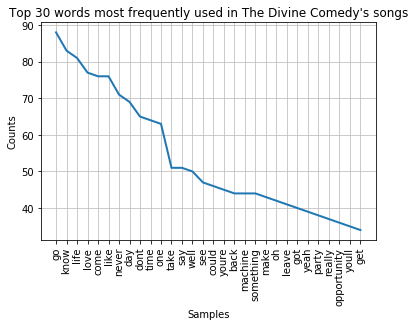

In [45]:
lists =  songs['removed_emptyim']
words = []
for wordList in lists:
    words += wordList

from nltk.probability import FreqDist
fd=FreqDist(words)
print(fd)

import matplotlib.pyplot as plt
fd.plot(30,cumulative=False,title='Top 30 words most frequently used in The Divine Comedy\'s songs')
plt.show()

To move on with **Sentiment Analysis**, NTLK offers its own built-in solution. The 'Compound' metric (which goes from -1 to 1) will give us an idea of which songs are more positive / negative.

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
songs['scores']=songs['cleaned'].apply(sia.polarity_scores)

In [23]:
def get_comp(dictio):
    comp=dictio['compound']
    return comp

In [24]:
songs['comp']=songs['scores'].apply(lambda x: get_comp(x))

I am interested in the most negative and most positive songs

In [ ]:
sortedsongs=songs.sort_values(by=['comp'])
most_neg=sortedsongs.head(15)
most_pos=sortedsongs.tail(15)

Text(0.5, 1.0, 'Most negative TDC Lyrics')

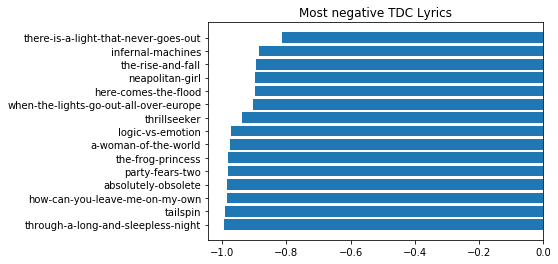

In [46]:
height = most_neg['comp']
bars = most_neg['song']

# Create bars
plt.barh(bars, height)
plt.title('Most negative TDC Lyrics')

Even though I see some tunes that I had no expected they would be catalogued as 'negative', when I take a look at the words frequency it makes sense to find words such as leave, dont, never, go, etc.

<FreqDist with 829 samples and 1829 outcomes>


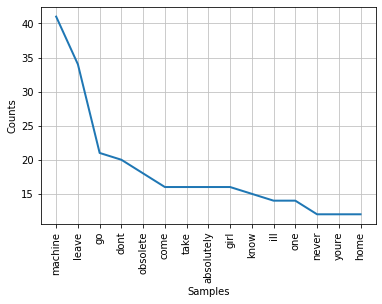

In [27]:
lists =  most_neg['removed_emptyim']
words = []
for wordList in lists:
    words += wordList

from nltk.probability import FreqDist
fd=FreqDist(words)
print(fd)

import matplotlib.pyplot as plt
fd.plot(15,cumulative=False)
plt.show()

Now let us see what comes up with the most positive songs...

Text(0.5, 1.0, 'TDC Lyrics with highest compound rate')

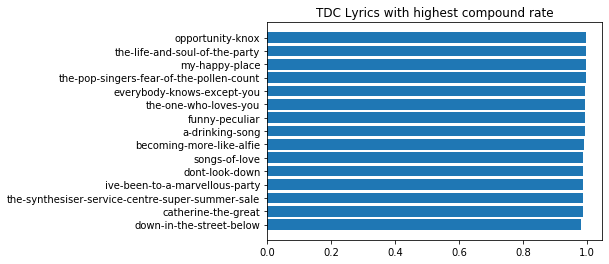

In [48]:
height = most_pos['comp']
bars = most_pos['song']

# Create bars
plt.barh(bars, height)
plt.title('TDC Lyrics with highest compound rate')

Not surprisingly we find love, opportunity, life as frequent words and these songs in particular can really raise your spirits so I invite you to listen to them :)

<FreqDist with 960 samples and 2206 outcomes>


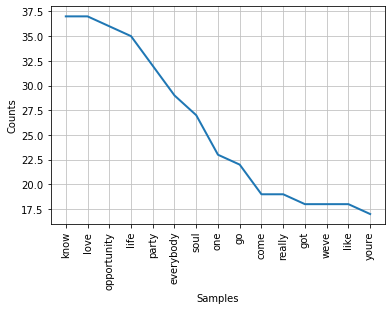

In [29]:
lists =  most_pos['removed_emptyim']
words = []
for wordList in lists:
    words += wordList

from nltk.probability import FreqDist
fd=FreqDist(words)
print(fd)

import matplotlib.pyplot as plt
fd.plot(15,cumulative=False)
plt.show()

To sum up, The Divine Comedy\'s lyrics tend to be placed more in the spectrum of positive as regards to sentiment. We can see that clearly in the next histogram where I draw a line to represent the median

0.8483499999999999

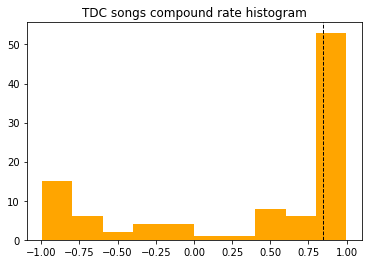

In [50]:
plt.hist(songs['comp'],color='orange')
plt.axvline(songs['comp'].median(), color='k', linestyle='dashed', linewidth=1)
plt.title('TDC songs compound rate histogram')
songs['comp'].median()

I am intrigued to see what happens with **The Smiths**. I expect to find some contrast...

In [31]:
urls = request_song_url('The Smiths', 25)
lyricsdict={}

for url in urls:
    lyrics = scrape_song_lyrics(url)
    lyricsdict[url]=lyrics

Found 25 songs by The Smiths


The contrast is clear, with half of the songs behind the negative -0.51 median of the compound rate

-0.5102

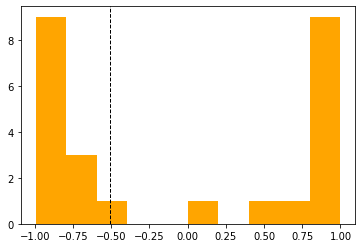

In [37]:
ts_songs=pd.DataFrame.from_dict(lyricsdict,orient='index')
ts_songs=ts_songs.reset_index()
ts_songs.columns=['song','lyrics']

def clean (text):
    pattern='\[(.*?)\]'
    new_text=re.sub(pattern,' ', text)
    new_text=new_text.replace('\n',' ')
    new_text_nonpunct="".join([char for char in new_text if char not in string.punctuation])
    return new_text_nonpunct

ts_songs['cleaned']=ts_songs['lyrics'].apply(clean)

ts_songs['scores']=ts_songs['cleaned'].apply(sia.polarity_scores)
ts_songs['comp']=ts_songs['scores'].apply(lambda x: get_comp(x))

plt.hist(ts_songs['comp'],color='orange')
plt.axvline(ts_songs['comp'].median(), color='k', linestyle='dashed', linewidth=1)
ts_songs['comp'].median()

Lastly, let us try a popular visualization tool for texts, which is **WordCloud**.

The first wordcloud shows the words used in the most positive songs of The Divine Comedy using the method that reads frequencies.

To try another method that reads text, I extract the The Smiths song with the lowest compound rate and this is reflected in the second blue wordcloud. 

<FreqDist with 960 samples and 2206 outcomes>


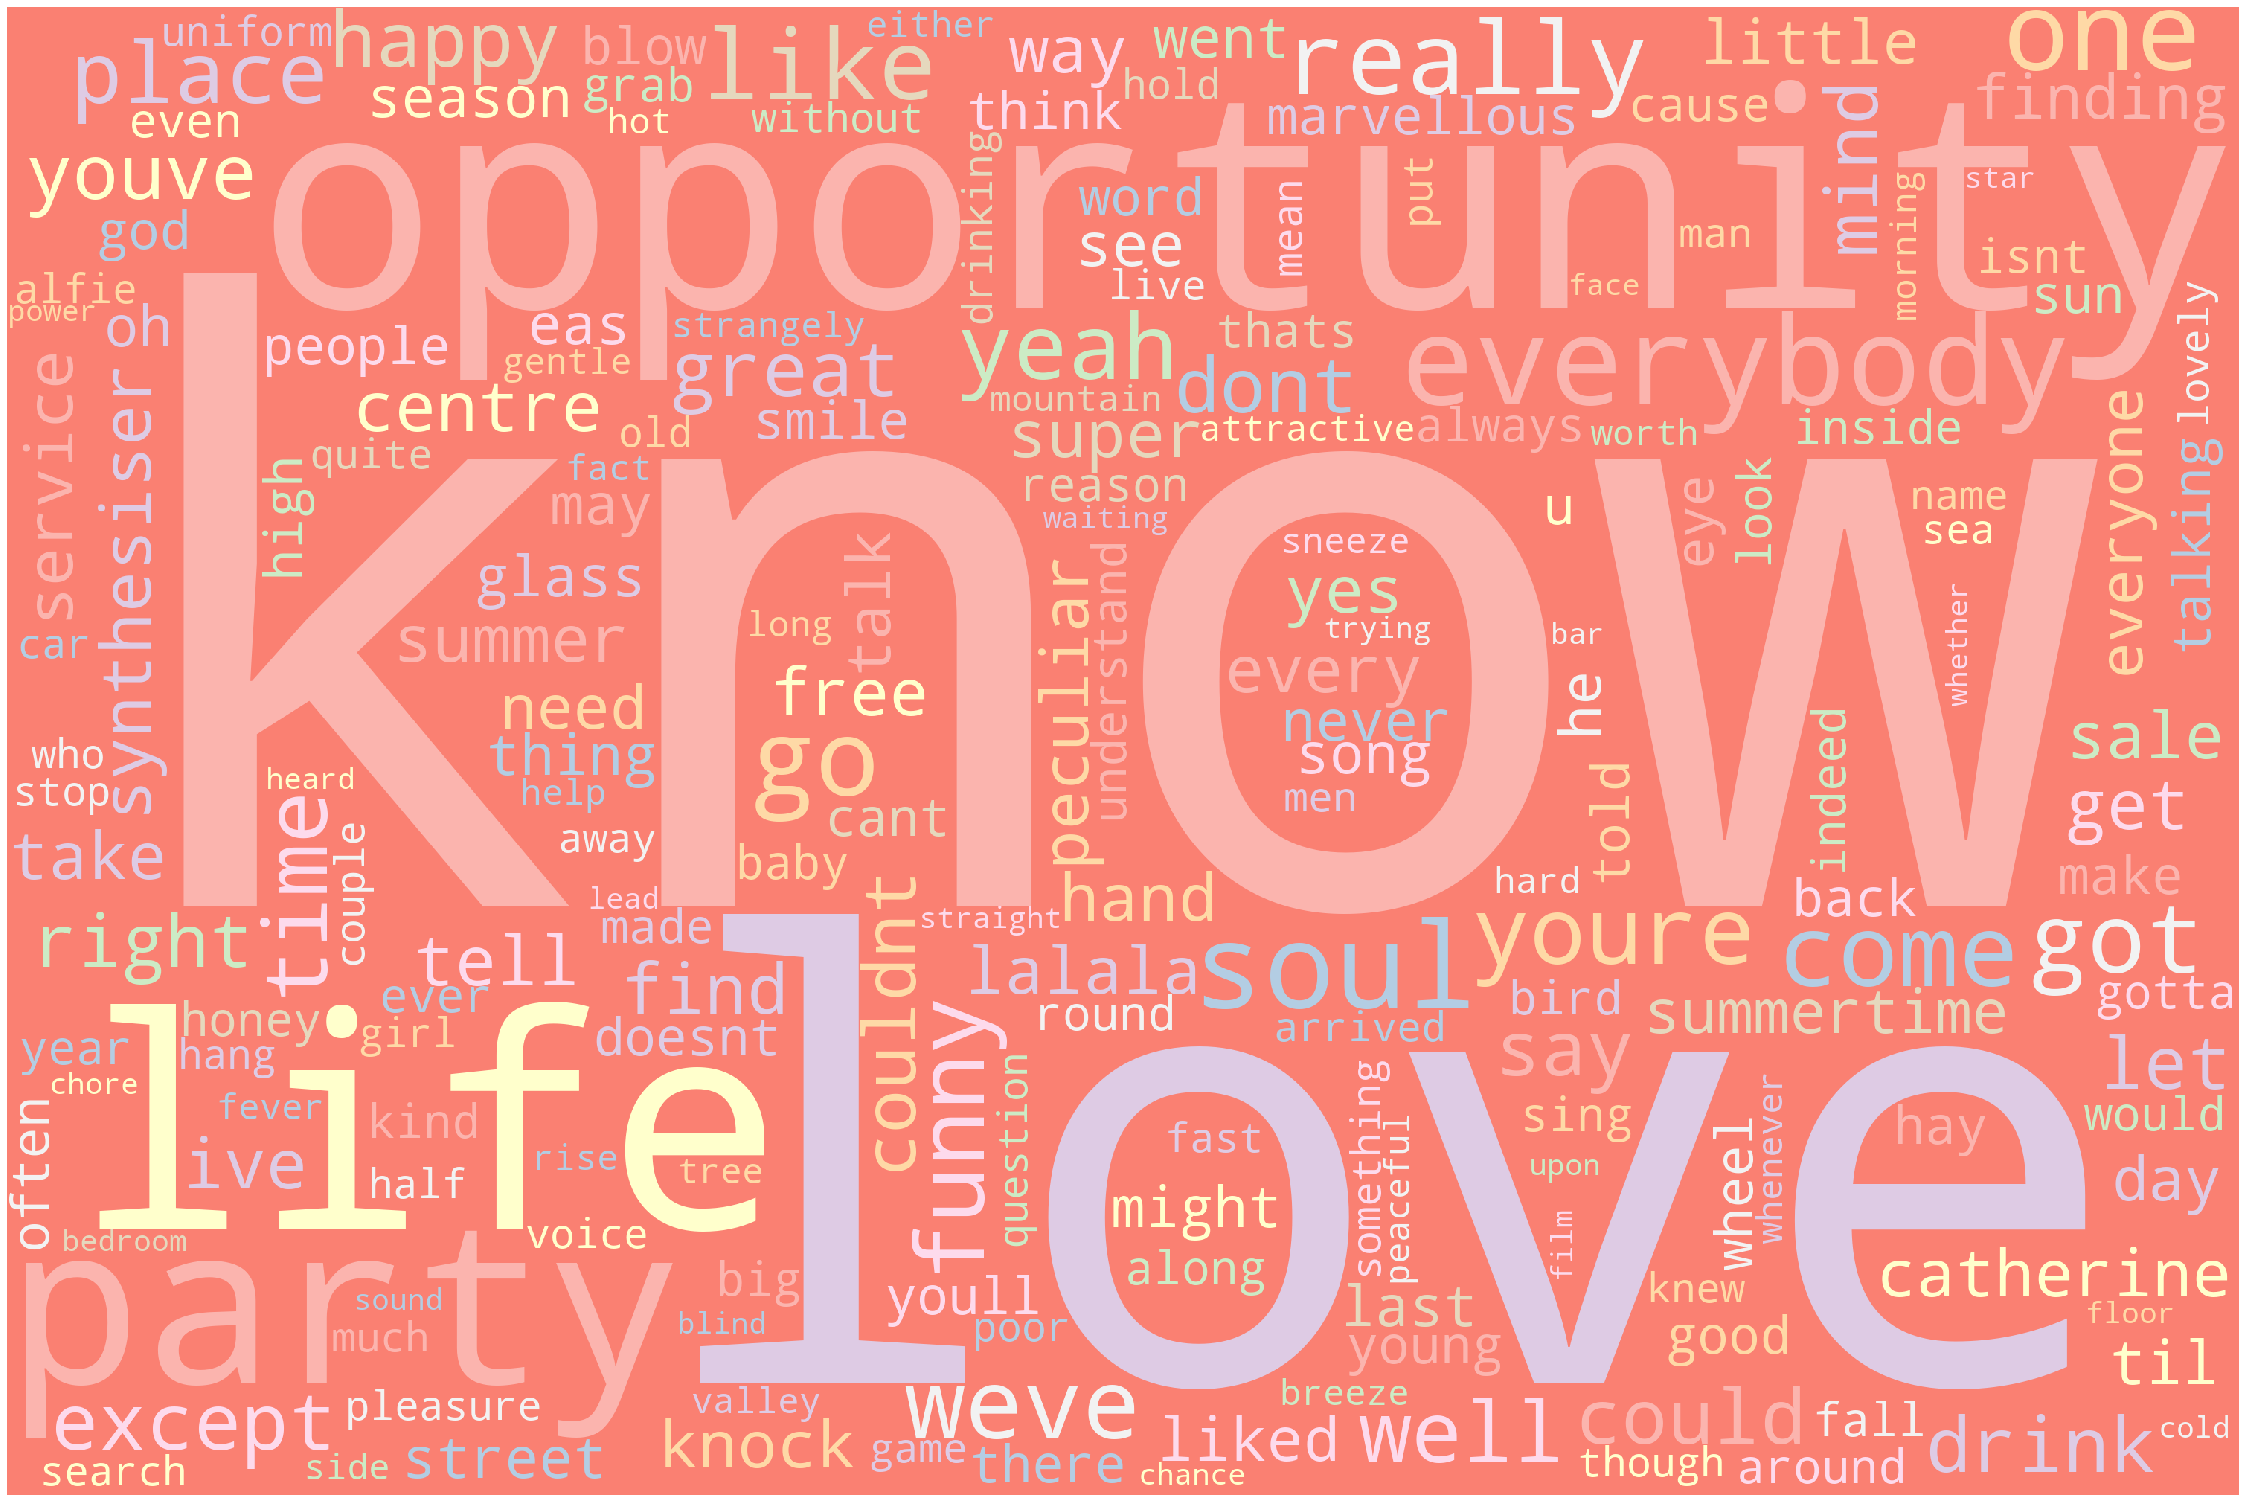

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Import package
from wordcloud import WordCloud
# Generate word cloud

lists =  most_pos['removed_emptyim']
words = []
for wordList in lists:
    words += wordList

from nltk.probability import FreqDist
fd=FreqDist(words)
print(fd)

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).fit_words(fd)
# Plot
plot_cloud(wordcloud)

In [38]:
ts_songs

,song,lyrics,cleaned,scores,comp
0,https://genius.com/The-smiths-there-is-a-light...,[Verse 1]\nTake me out tonight\nWhere there's ...,Take me out tonight Where theres music and t...,"{'neg': 0.155, 'neu': 0.719, 'pos': 0.125, 'co...",-0.9460
1,https://genius.com/The-smiths-this-charming-ma...,[Verse 1]\nPunctured bicycle on a hillside des...,Punctured bicycle on a hillside desolate Wil...,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...",0.9922
2,https://genius.com/The-smiths-i-know-its-over-...,"[Verse 1]\nOh Mother, I can feel the soil fall...",Oh Mother I can feel the soil falling over m...,"{'neg': 0.068, 'neu': 0.686, 'pos': 0.246, 'co...",0.9981
3,https://genius.com/The-smiths-bigmouth-strikes...,"\n\n[Verse]\nSweetness, sweetness I was only j...",Sweetness sweetness I was only joking when...,"{'neg': 0.112, 'neu': 0.812, 'pos': 0.076, 'co...",-0.7269
4,https://genius.com/The-smiths-how-soon-is-now-...,[Intro]\n\n[Verse 1]\nI am the son and the hei...,I am the son and the heir Of a shyness th...,"{'neg': 0.1, 'neu': 0.764, 'pos': 0.136, 'comp...",0.8313
5,https://genius.com/The-smiths-heaven-knows-im-...,[Verse 1]\nI was happy in the haze of a drunke...,I was happy in the haze of a drunken hour Bu...,"{'neg': 0.155, 'neu': 0.675, 'pos': 0.17, 'com...",0.5448
6,https://genius.com/The-smiths-asleep-lyrics,[Verse 1]\nSing me to sleep\nSing me to sleep\...,Sing me to sleep Sing me to sleep Im tired a...,"{'neg': 0.038, 'neu': 0.785, 'pos': 0.177, 'co...",0.9483
7,https://genius.com/The-smiths-cemetry-gates-ly...,[Chorus]\nA dreaded sunny day\nSo I meet you a...,A dreaded sunny day So I meet you at the cem...,"{'neg': 0.097, 'neu': 0.82, 'pos': 0.083, 'com...",-0.7102
8,https://genius.com/The-smiths-please-please-pl...,"\n\n[Verse 1]\nGood times for a change\nSee, t...",Good times for a change See the luck Ive h...,"{'neg': 0.093, 'neu': 0.672, 'pos': 0.235, 'co...",0.8844
9,https://genius.com/The-smiths-some-girls-are-b...,[Verse 1]\nFrom the ice age to the dole age\nT...,From the ice age to the dole age There is bu...,"{'neg': 0.025, 'neu': 0.94, 'pos': 0.034, 'com...",0.0772


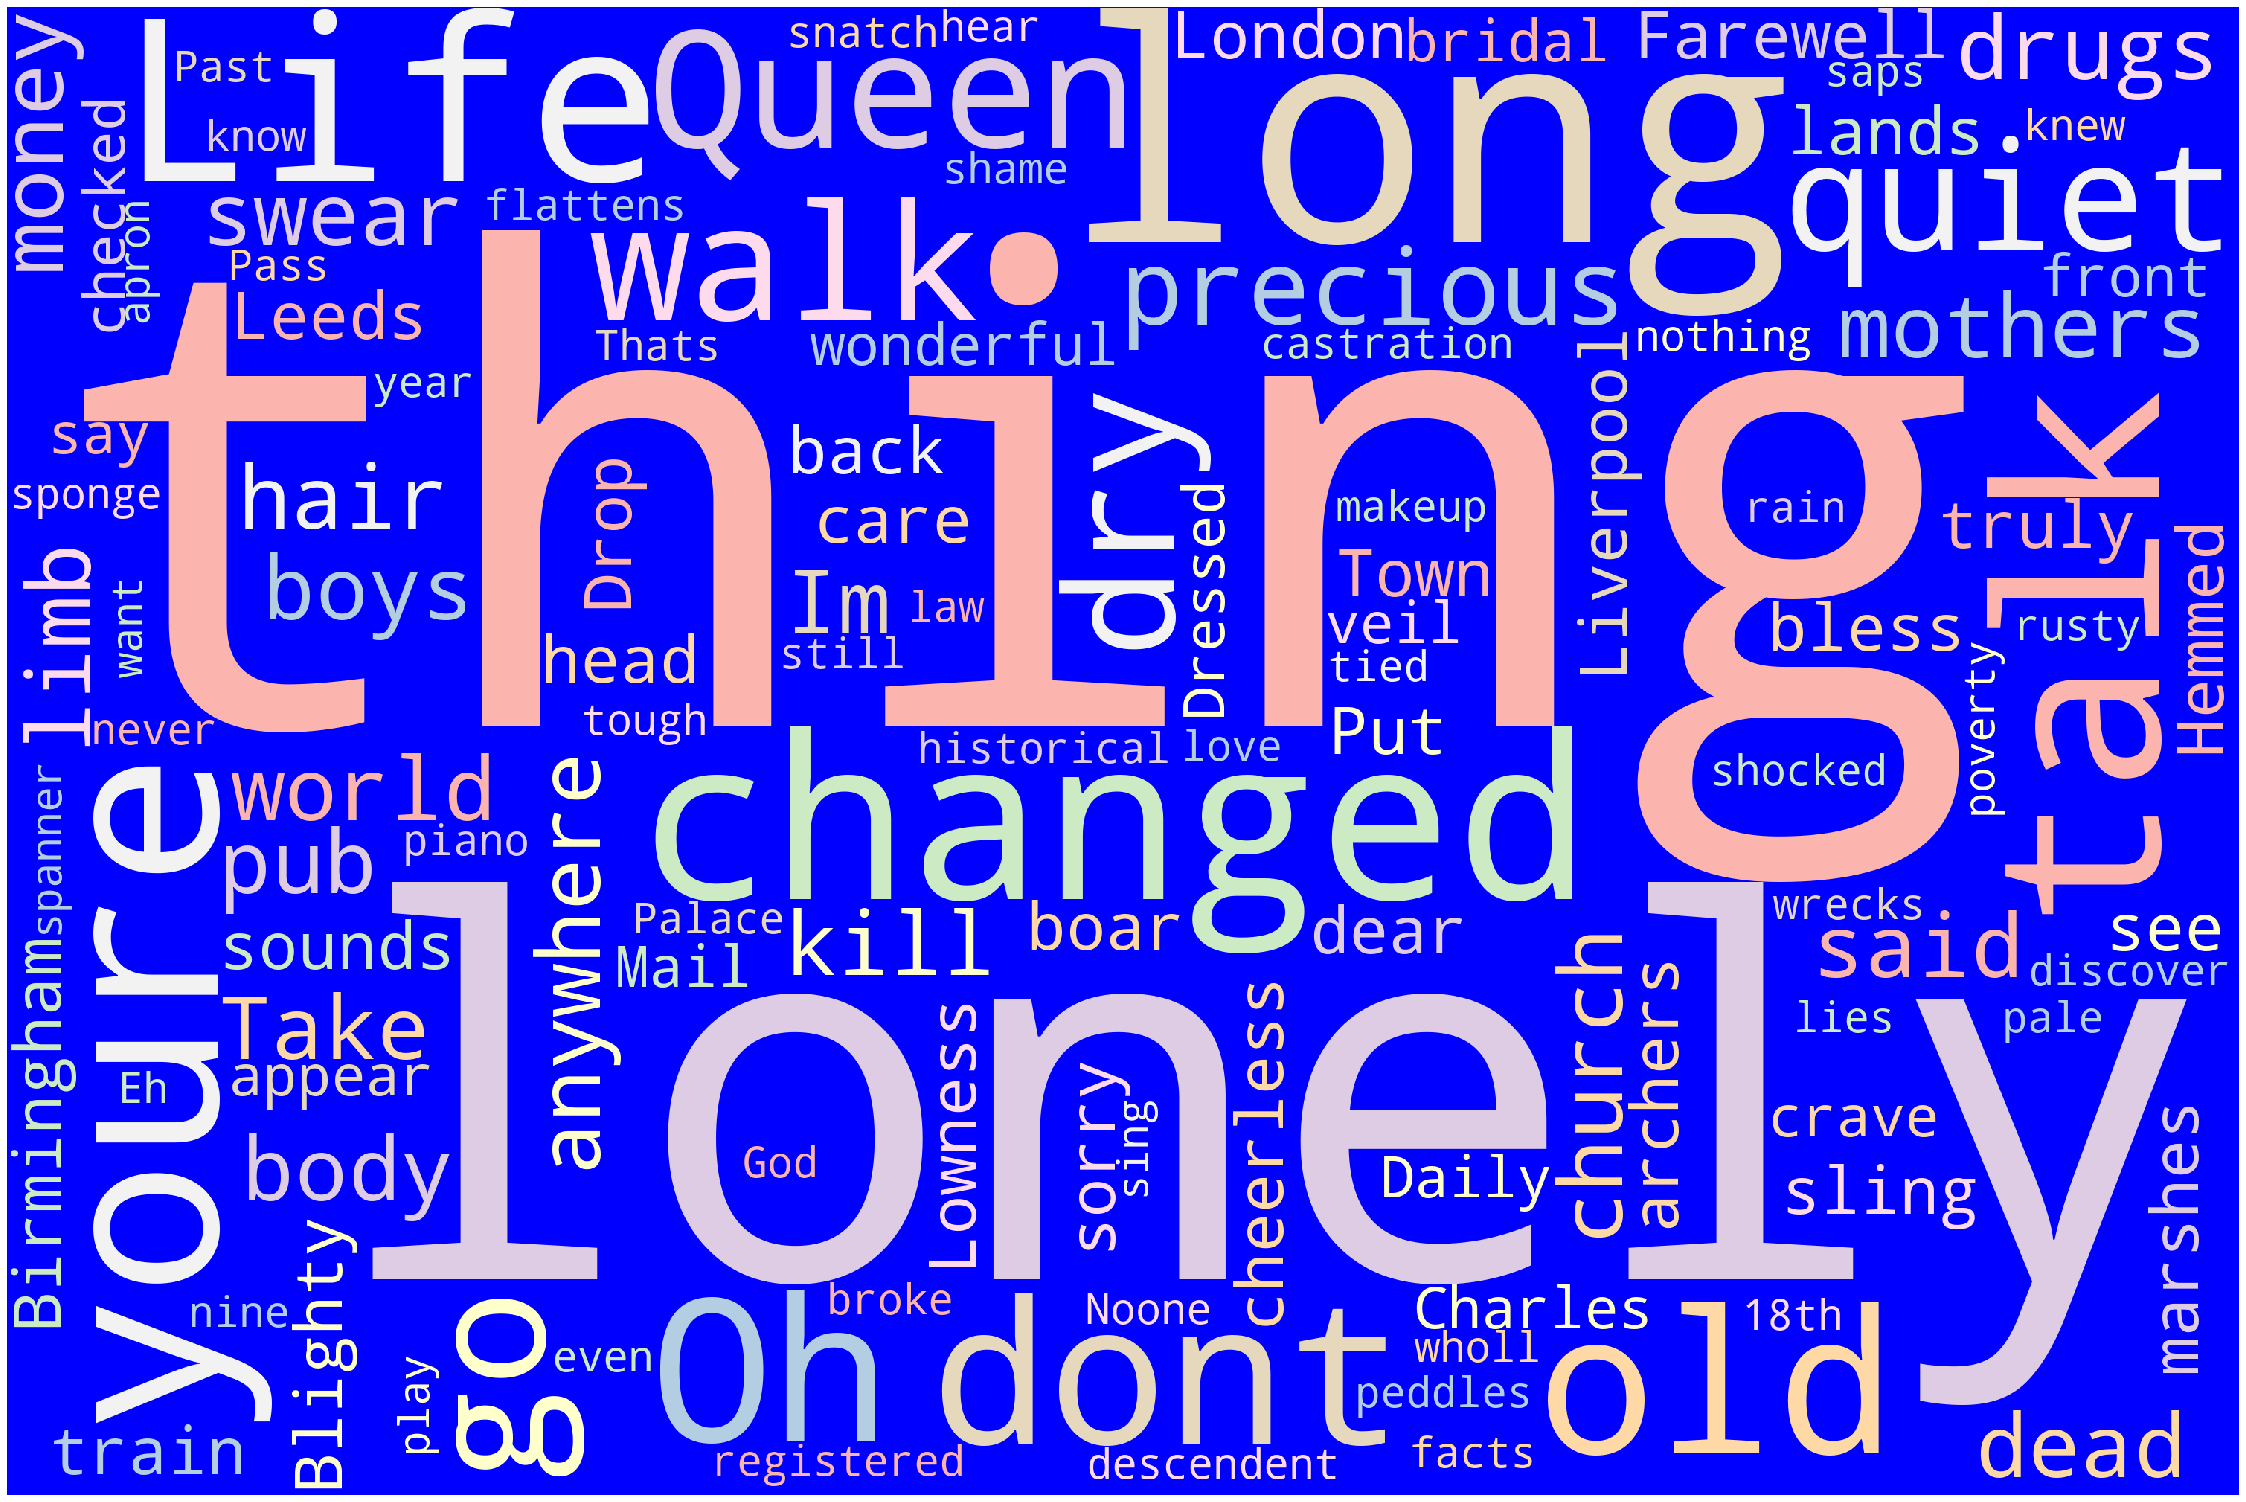

In [39]:
ind=ts_songs['comp'].idxmin
text=ts_songs['cleaned'][ind]
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', colormap='Pastel1', collocations=False).generate(text)
# Plot
plot_cloud(wordcloud)